# Preprocesamiento de datos

Con el fin de poder entrenar los diversos modelos de Machine Learning y
Deep learning, es necesário hacer un preprocesamiento de los datos para 
poder obtener un único DataFrame con todas las características necesárias

## Carga de datos

Antes de poder manipular los diferentes datos, primero es necesário
cargarlos en el sistema

In [20]:
import pandas as pd
import polars as pl
import numpy as np 
from pathlib import Path

In [21]:
# Directório de archivos
data_folder = Path("../data/predict-energy-behavior-of-prosumers")

# Diccionario de archivos
files = {
    "train": "train.csv",
    "gas_prices": "gas_prices.csv",
    "client": "client.csv",
    "electricity_prices": "electricity_prices.csv",
    "forecast_weather": "forecast_weather.csv",
    "historical_weather": "historical_weather.csv",
    "county_lon_lats": "county_lon_lats.csv"
}

In [22]:
dfs = {}

for key, filename in files.items():
    filepath = data_folder / filename
    try:
        df = pl.read_csv(filepath)
        dfs[key] = df
        print(f"Archivo {key} cargado con exito.")
    except:
        print(f"No pudo cargarse el archivo {key}.")
    

Archivo train cargado con exito.
Archivo gas_prices cargado con exito.
Archivo client cargado con exito.
Archivo electricity_prices cargado con exito.
Archivo forecast_weather cargado con exito.
Archivo historical_weather cargado con exito.
Archivo county_lon_lats cargado con exito.


## Asignación de longitud/latitud a un condado especifico

Con el fin de poder unir los csv de "train.csv" y "forecast_weather.csv"
es necesario poder asignar a cada longitud y latitud, su condado
correspondiente.

Para ello se utilizará el archivo "county_lon_lats" obtenido de la página
de [kaggle](https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data)
con datos que asignan latitudes y longitudes a su correspondiente condado.

### Visualización de los datos

In [23]:
import matplotlib.pyplot as plt

In [24]:
dfs["county_lon_lats"] = dfs["county_lon_lats"].drop("")
dfs["county_lon_lats"].head()

county,longitude,latitude
i64,f64,f64
0,24.2,59.1
0,25.2,59.1
0,23.7,59.4
0,24.2,59.4
0,24.7,59.4


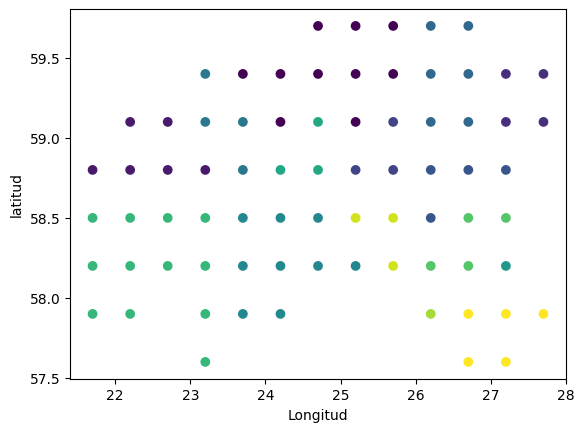

In [25]:
plt.scatter('longitude', 'latitude', c='county', data=dfs["county_lon_lats"])
plt.xlabel("Longitud")
plt.ylabel("latitud")
plt.show()

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings("ignore")

In [73]:
# Se preparan los datos de entrenamiento y prueba
skf = StratifiedKFold(10, shuffle=True)

# obtención de X e y
X = dfs["county_lon_lats"].drop("county")
y = dfs["county_lon_lats"]["county"].to_numpy()

# Escalado de X para entrenamiento del modelo
X_scl = MinMaxScaler().fit_transform(X)

# Número de clusters o regiones
n_clusters = np.arange(start=1, stop=15)
n_neighbors = np.arange(start=1, step=2, stop=21)

### KMeans

In [74]:
train_scores = np.array([])
test_scores = np.array([])

for i in n_clusters:
    
    fold_train_scores = np.array([])
    fold_test_scores = np.array([])

    for train_idx, test_idx in skf.split(X_scl, y):
        X_train, X_test = X_scl[train_idx], X_scl[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        km = KMeans(n_clusters=i)

        km.fit(X_train, y_train)

        fold_train_scores = np.append(
            fold_train_scores,
            accuracy_score(y_train, km.predict(X_train))
            #km.score(X_train, y_train)
        )

        fold_test_scores = np.append(
            fold_test_scores,
            accuracy_score(y_test, km.predict(X_test))
            #km.score(X_test, y_test)
        )
    
    train_scores = np.append(train_scores, fold_train_scores.mean())
    test_scores = np.append(test_scores, fold_test_scores.mean())


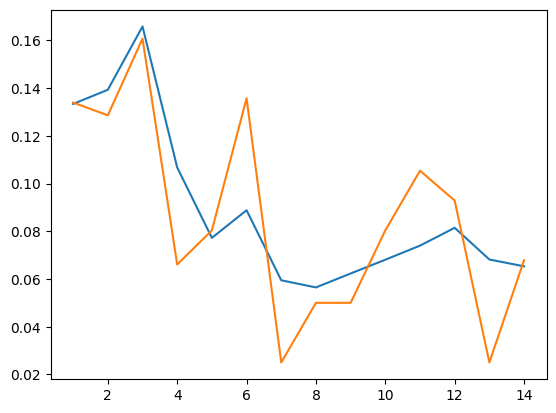

In [75]:
plt.plot(n_clusters, train_scores)
plt.plot(n_clusters, test_scores)
plt.show()

In [59]:
train_scores = np.array([])
test_scores = np.array([])

for i in n_neighbors:
    fold_train_scores = np.array([])
    fold_test_scores = np.array([])

    for train_idx, test_idx in skf.split(X_scl, y):
        X_train, X_test = X_scl[train_idx], X_scl[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(X_train, y_train)

        fold_train_scores = np.append(
            fold_train_scores,
            accuracy_score(y_train, knn.predict(X_train))
            #knn.score(X_train, y_train)
        )

        fold_test_scores = np.append(
            fold_test_scores,
            accuracy_score(y_test, knn.predict(X_test))
            #knn.score(X_test, y_test)
        )
    
    train_scores = np.append(train_scores, fold_train_scores.mean())
    test_scores = np.append(test_scores, fold_test_scores.mean())

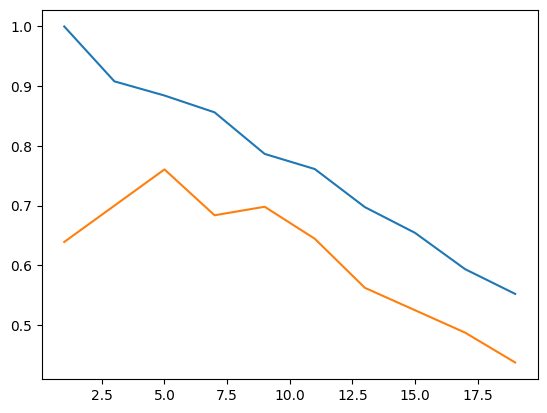

In [60]:
plt.plot(n_neighbors, train_scores)
plt.plot(n_neighbors, test_scores)
plt.show()